In [2]:
cd /home/jovyan/GA_DSI/Projects/capstone

/home/jovyan/GA_DSI/Projects/capstone


In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lib.general_utilities as gu

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline

from collections import Counter
import itertools
from wordcloud import WordCloud
import seaborn as sns

from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix 
from sklearn.metrics import (precision_score,accuracy_score,roc_auc_score,roc_curve, 
                             precision_recall_curve,recall_score,make_scorer,auc)
from tqdm import tqdm

# storing data directories for this notebook.
img_out_dir = 'data/images/Benchmark_NB3/'
data_out_dir = 'data/pickled/Benchmark_NB3/'

%matplotlib inline

## Let's run our text data, through some models and see how they predict.

```At this point I have the following data that I want to compare results for:```
```
1. raw text
2. cleaned text
3. stopwords processed and cleaned text
4. stemmed, stopwords processed and cleaned text```

In [3]:
# read my pickled dataframes, with processed and cleaned text. I split the data processing
# into 2 parts since kernel kept dying. I will append them together now. 
# note: need to reset index.
filename1 = 'data/pickled/EDA_NB1/airline_cl_process_dataset_df1'
filename2 = 'data/pickled/EDA_NB2/airline_cl_process_dataset_df2'
df1 = gu.read_pickle_obj(filename1)
df2 = gu.read_pickle_obj(filename2)

In [16]:
# append dataframes.
air_full_df = df1.append(df2)
# fix index.
air_full_df.reset_index(inplace=True)
# drop column 'index' added by pandas, not needed.
air_full_df.drop(['index'], axis=1, inplace=True)

col_order = ['airline', 'airline_sentiment', 'text', 'clean_text', 'stopw_clean_text',
             'stem_stopw_clean_text', 'negativereason', 'airline_sentiment_confidence']

# set column order
air_full_df = air_full_df[col_order]
# pickle appended dataframe.
gu.pickle_obj(data_out_dir+'airline_cl_process_full_dataset_70perc_conf_df', air_full_df)

In [17]:
#***********************************************************************************

In [4]:
# Load dataset.
filename = data_out_dir+'airline_cl_process_full_dataset_70perc_conf_df'
air_full_df = gu.read_pickle_obj(filename)

In [5]:
air_full_df.head()

,airline,airline_sentiment,text,clean_text,stopw_clean_text,stem_stopw_clean_text,negativereason,airline_sentiment_confidence
0,Virgin America,neutral,@VirginAmerica What @dhepburn said.,AT_USER what AT_USER said.,said.,said.,NaN,1.0
1,Virgin America,negative,@VirginAmerica it's really aggressive to blast...,AT_USER it's really aggressive to blast obnoxi...,"it's really aggressive blast obnoxious ""entert...","it' realli aggress blast obnoxi ""entertainment...",Bad Flight,1.0
2,Virgin America,negative,@VirginAmerica and it's a really big bad thing...,AT_USER and it's a really big bad thing about it,it's really big bad thing,it' realli big bad thing,Can't Tell,1.0
3,Virgin America,negative,@VirginAmerica seriously would pay $30 a fligh...,AT_USER seriously would pay $30 a flight for s...,seriously pay $30 seats didn't playing. it's r...,serious pay $30 seat didn't playing. it' reall...,Can't Tell,1.0
4,Virgin America,positive,"@VirginAmerica it was amazing, and arrived an ...","AT_USER it was amazing, and arrived an hour ea...","amazing, arrived hour early. you're good me.","amazing, arriv hour early. you'r good me.",NaN,1.0


In [6]:
# dataset size.
air_full_df.shape

(10768, 8)

In [7]:
# column names
air_full_df.columns

Index(['airline', 'airline_sentiment', 'text', 'clean_text',
       'stopw_clean_text', 'stem_stopw_clean_text', 'negativereason',
       'airline_sentiment_confidence'],
      dtype='object')

In [8]:
# airlines.
air_full_df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

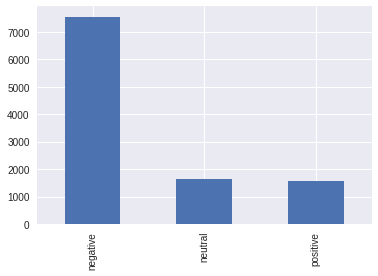

In [9]:
air_full_df.airline_sentiment.value_counts().plot(kind='bar')

In [10]:
#****** Highly imbalanced. 

In [11]:
def log_output(dataset_name, model_name, sc_output, pipe):
    '''
    This method logs the output of a model pipeline.
    '''
    
    entry = {                
                'dataset'        :  dataset_name,
                'model'          :  model_name,
                'tr_acc_score'   :  sc_output['train_score'],
                'tst_acc_score'  :  sc_output['test_score'],
                'true_pos_rate'  :  sc_output['true_pos_rate'],
                'false_pos_rate' :  sc_output['false_pos_rate'],
                'thresholds'     :  sc_output['thresholds'],
                'pipe_object'    :  pipe
            }
    return(entry)

In [12]:
# Gridsearch to find best model.
def gs_fit_score_pipeline(pipe, Xtrain, Xtest, ytrain, ytest, param_grid, target_names):
    '''
    This method grid searches a pipeline, with parameters in the param_grid, 
    to find best model with tuned hyper paramters.
    '''
    
    gs = GridSearchCV(pipe, cv = 5, param_grid=param_grid)
  
    # Fit and score pipeline.
    gs.fit(Xtrain, ytrain) 
    
    # Mean accuracy score is returned.
    train_score = gs.score(Xtrain,ytrain)
    test_score = gs.score(Xtest,ytest)  
    y_pred = gs.predict(Xtest)
       
    output = {'train_score':train_score, 
              'test_score':test_score,
              }
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
    
    return(output, class_report_str, conf_matrix_raw)

In [13]:
# fit score pipeline of models. Good for benchmarking.
def fit_score_pipeline(pipe, X, y, target_names):
    '''
    This method fits and scores pipeline of models. Its good for benchmarking.
    '''    
  
    # train test split our X and y.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=42)
    # Fit and score pipeline.
    pipe.fit(Xtrain, ytrain) 
    
    # Mean accuracy score is returned.
    train_score = pipe.score(Xtrain,ytrain)
    test_score = pipe.score(Xtest,ytest)  
    y_pred = pipe.predict(Xtest)
        
        
    output = {'train_score':train_score, 
              'test_score':test_score,
              }  
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
    
    return(output, class_report_str, conf_matrix_raw)

In [14]:
def execute_pipeline(pipe, param_grid, X, y, target_names, model_results, model_name,
                     classification_rep, confusion_mtx, data_desc):
    '''
    This method manages the pipeline fit and score execution, and keeps track of logging
    the results.  
    '''
                                    
    # Fit, score and get model stats.                                           
    sc_output, cl_report_str, conf_mtx = fit_score_pipeline(pipe, 
                                                            X,
                                                            y,
                                                            target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    key = model_name+" "+data_desc
    classification_rep[key] = cl_report_str
    key = model_name+" "+data_desc
    confusion_mtx[key] = conf_mtx
    
    # Log results.
    entry = log_output( dataset_name = data_desc, 
                        model_name   = model_name, 
                        sc_output    = sc_output,
                        pipe         = pipe)

    # Append the output for this model to a list.
    model_results.append(entry)

In [15]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          isNorm = False):
    '''
    This function plots and saves the confusion matrix.
    '''
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid('off')

    if (isNorm):
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    plt.savefig(img_out_dir+'BM_'+title+'.png')   
    plt.show()

In [16]:
def classifaction_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return(dataframe)

In [17]:
def plot_point(data, x, y, hue, title):    
    plt.figure(figsize=(8, 6))
    sns.pointplot(x=x, y=y, hue=hue, data=data)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.title(title)
    plt.tight_layout()

In [18]:
def plot_bar(data, x, y, hue, title):    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y=y, hue=hue, data=data)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.title(title)
    plt.tight_layout()

In [19]:
def plot_ROC(fpr,tpr,title, roc_auc):
    plt.title('Receiver Operating Characteristic '+title)
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(img_out_dir+'BM_ROC_'+title+'.png')
    plt.show()

## Create pipeline for benchmarking.

In [20]:
# target.
y = air_full_df['airline_sentiment']

In [21]:
y.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [22]:
# Encode the target categories to a numeric number, using one hot encoding.
encoder = LabelEncoder()
y = encoder.fit_transform(air_full_df['airline_sentiment'])

In [23]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [24]:
# value counts of each class.
Counter(y)

Counter({0: 7552, 1: 1634, 2: 1582})

In [25]:
# 0:Negative, 1:neutral, 2:positive
# Classes of training data are imbalanced. 

In [26]:
# Create a document token matrix with CountVectorizer here. We are creating a numerical 
# representation of the words based on their count frequency in the 
# documents(in this case tweets)

In [27]:
# NOTE: RUN MODELS WITH CLEAN, STOPW_CLEAN and STEM_STOPW_CLEAN, text. Is there a difference
# in accuracy?

In [28]:
# NOTE: Analyze why I selected to run these.

In [29]:
# Make a dictionary of models to run.
# Using high C value for SVC and LR to provide minimal regularization.
modelsToexecute_dict = {'NaiveBayes': {'model':MultinomialNB(),
                                        'param_grid': ''},
                                'SVC': {'model':SVC(C=1000),
                                        'param_grid': ''},
             'DecisionTreeClassifier': {'model':DecisionTreeClassifier(),
                                        'param_grid': ''},
             'RandomForestClassifier': {'model':RandomForestClassifier(),
                                        'param_grid':''},
                 'LogisticRegression': {'model':LogisticRegression(C=1000),
                                        'param_grid':''}                     
                       }

In [36]:
data_to_use = ['clean_text', 'stopw_clean_text', 'stem_stopw_clean_text']
data_desc = ["clean text", "remove stopwords", "applied stemming"]

In [35]:
# feature extraction and vectorization of text data. 
cv_dict = {'cv_ngrams_1_1': CountVectorizer(ngram_range=(1,1)),
           'cv_ngrams_1_2': CountVectorizer(ngram_range=(1,2)),
           'cv_ngrams_1_3': CountVectorizer(ngram_range=(1,3))}         

In [ ]:
def run_ngram_vectorizer(cv):

    # Save mean accuracy scores, classification reports and confusion matrix.
    model_results = []
    confusion_mtx = {}
    classification_rep = {}
    cv_vectorizers = []
    target_names=['negative', 'neutral', 'positive']

    for ind, text_set in tqdm(enumerate(data_to_use)):
        print("text data used for this iteration: "+ text_set)
        # feature extraction.
        X_cv = cv.fit_transform(air_full_df[text_set])

        for model_name, params in modelsToexecute_dict.items():  
            print("trainiing model: "+ model_name)
            model = params['model']
            param_grid = params['param_grid']

            # Create a pipeline for the model.
            pipe = make_pipeline(model)

            execute_pipeline(pipe, param_grid, X_cv, y, target_names, model_results, model_name,
                             classification_rep, confusion_mtx, data_desc[ind])
            
            return(model_results, classification_rep, confusion_mtx)

In [57]:
# Save mean accuracy scores, classification reports and confusion matrix.
model_results = []
confusion_mtx = {}
classification_rep = {}
cv_vectorizers = []
target_names=['negative', 'neutral', 'positive']

for ind, text_set in tqdm(enumerate(data_to_use)):
    print("text data used for this iteration: "+ text_set)
    # feature extraction.
    X_cv = cv.fit_transform(air_full_df[text_set])
    
    for model_name, params in modelsToexecute_dict.items():  
        print("trainiing model: "+ model_name)
        model = params['model']
        param_grid = params['param_grid']
        
        # Create a pipeline for the model.
        pipe = make_pipeline(model)
                
        execute_pipeline(pipe, param_grid, X_cv, y, target_names, model_results, model_name,
                         classification_rep, confusion_mtx, data_desc[ind])
        


0it [00:00, ?it/s]

text data used for this iteration: clean_text
trainiing model: NaiveBayes
trainiing model: SVC



Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



trainiing model: DecisionTreeClassifier
trainiing model: RandomForestClassifier
trainiing model: LogisticRegression


1it [00:49, 49.88s/it]

text data used for this iteration: stopw_clean_text
trainiing model: NaiveBayes
trainiing model: SVC
trainiing model: DecisionTreeClassifier
trainiing model: RandomForestClassifier
trainiing model: LogisticRegression


2it [01:22, 41.28s/it]

text data used for this iteration: stem_stopw_clean_text
trainiing model: NaiveBayes
trainiing model: SVC
trainiing model: DecisionTreeClassifier
trainiing model: RandomForestClassifier
trainiing model: LogisticRegression


3it [01:56, 38.69s/it]


In [46]:
# Put all modelling results in a dataframe.
model_results_df = pd.DataFrame(model_results)

# I am specifying the column arrangements.
model_results_df = model_results_df[['dataset', 'model', 'tr_acc_score', 'tst_acc_score',
                                     'true_pos_rate', 'false_pos_rate', 'thresholds',
                                     'pipe_object']]

In [47]:
# classification reports are returned by sklearn as a string.
# make it into a dataframe.
cl_report_df = pd.DataFrame()
dframes = []
for k,v in classification_rep.items():

    df = classifaction_report_df(v)    
    modname_desc = k.split()
    
    df['model'] = str(modname_desc[0])
    df['data_desc'] = str(' '.join(modname_desc[1:]))
    dframes.append(df)
    #print('*****  ' + k + '  Classification Report *****', '\n\n', v, '\n')
    
cl_report_df = pd.concat(dframes)
cl_report_df.reset_index(inplace=True)
cl_report_df.drop("index", axis=1, inplace=True)

In [55]:
# pickle benchmark results.

gu.pickle_obj(data_out_dir+'benchmark_model_results_ngrams1_3_df', model_results_df)
gu.pickle_obj(data_out_dir+'benchmark_count_vectorizers_ngrams1_3.obj', cv_vectorizers)
gu.pickle_obj(data_out_dir+'benchmark_class_report_ngrams1_3_df.obj', cl_report_df)
gu.pickle_obj(data_out_dir+'benchmark_class_report_dict_ngrams1_3.obj', classification_rep)

In [59]:
model_results_df

,dataset,model,tr_acc_score,tst_acc_score,true_pos_rate,false_pos_rate,thresholds,pipe_object
0,clean text,NaiveBayes,0.972835,0.824977,"[0.0, 0.638157894737, 0.657894736842, 1.0]","[0.0, 0.0232432432432, 0.127567567568, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('multinomialnb', MultinomialN..."
1,clean text,SVC,0.851753,0.795729,"[0.0, 0.539473684211, 0.546052631579, 1.0]","[0.0, 0.0156756756757, 0.0562162162162, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('svc', SVC(C=1000, cache_size..."
2,clean text,DecisionTreeClassifier,0.999420,0.786444,"[0.0, 0.618421052632, 0.723684210526, 1.0]","[0.0, 0.0448648648649, 0.208108108108, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('decisiontreeclassifier', Dec..."
3,clean text,RandomForestClassifier,0.983167,0.786908,"[0.0, 0.467105263158, 0.5, 1.0]","[0.0, 0.00972972972973, 0.0621621621622, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('randomforestclassifier', Ran..."
4,clean text,LogisticRegression,0.999420,0.879294,"[0.0, 0.743421052632, 0.802631578947, 1.0]","[0.0, 0.0172972972973, 0.178378378378, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('logisticregression', Logisti..."
5,remove stopwords,NaiveBayes,0.966798,0.788301,"[0.0, 0.717105263158, 0.756578947368, 1.0]","[0.0, 0.0578378378378, 0.191351351351, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('multinomialnb', MultinomialN..."
6,remove stopwords,SVC,0.797655,0.761838,"[0.0, 0.536184210526, 0.536184210526, 1.0]","[0.0, 0.0318918918919, 0.04, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('svc', SVC(C=1000, cache_size..."
7,remove stopwords,DecisionTreeClassifier,0.999071,0.793408,"[0.0, 0.707236842105, 0.802631578947, 1.0]","[0.0, 0.0605405405405, 0.244864864865, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('decisiontreeclassifier', Dec..."
8,remove stopwords,RandomForestClassifier,0.987346,0.808728,"[0.0, 0.628289473684, 0.746710526316, 1.0]","[0.0, 0.0378378378378, 0.185945945946, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('randomforestclassifier', Ran..."
9,remove stopwords,LogisticRegression,0.999071,0.840761,"[0.0, 0.720394736842, 0.822368421053, 1.0]","[0.0, 0.0313513513514, 0.198918918919, 1.0]","[3, 2, 1, 0]","Pipeline(steps=[('logisticregression', Logisti..."


In [53]:
cl_report_df.head(5)

,class,f1_score,precision,recall,support,model,data_desc
0,negative,0.89,0.83,0.95,1500.0,NaiveBayes,clean text
1,neutral,0.55,0.76,0.43,350.0,NaiveBayes,clean text
2,positive,0.72,0.82,0.64,304.0,NaiveBayes,clean text
3,negative,0.87,0.79,0.99,1500.0,SVC,clean text
4,neutral,0.33,0.92,0.20,350.0,SVC,clean text


## Visualize Classification Report Metrics.

In [51]:
# read in pickled classification data.
cl_report_df = gu.read_pickle_obj(data_out_dir+'benchmark_class_report_df.obj')

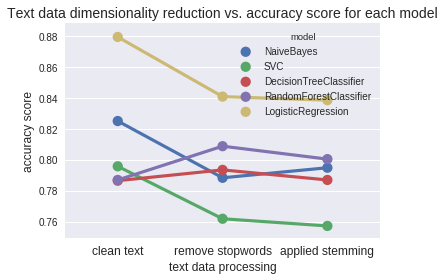

In [52]:
sns.pointplot(x="dataset", y= "tst_acc_score", hue="model", data=model_results_df)
plt.title('Text data dimensionality reduction vs. accuracy score for each model',
          fontsize=14)
plt.xlabel('text data processing', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('accuracy score', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_model_perf_vs_feat_dim_reduction.png')

### Let's look at the classification report metrics: precision and recall, and confusion matrix

In [ ]:
# ROC is for binary classification, I have a multiclass, so plot confusion matrix.

# confusion matrix is used to evaluate the quality of the output of a classifier.
# The diagonal elements represent the number of points for which the predicted label 
# is equal to the true label, while off-diagonal elements are those that are mislabeled
# by the classifier.

Normalized confusion matrix
[[ 0.96  0.02  0.02]
 [ 0.51  0.42  0.07]
 [ 0.35  0.03  0.62]]


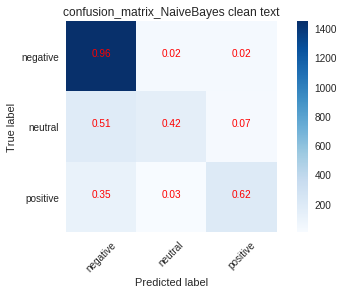

Normalized confusion matrix
[[ 0.88  0.09  0.03]
 [ 0.34  0.59  0.06]
 [ 0.19  0.09  0.72]]


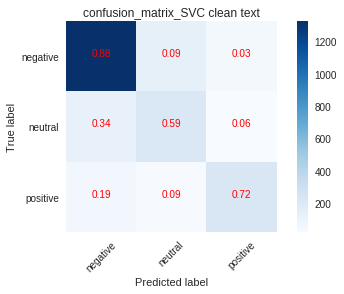

Normalized confusion matrix
[[ 0.86  0.09  0.04]
 [ 0.38  0.53  0.09]
 [ 0.28  0.12  0.61]]


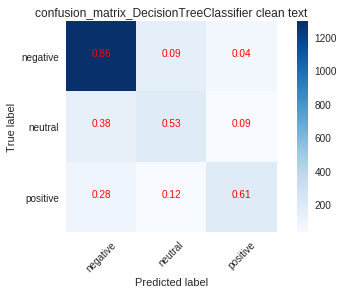

Normalized confusion matrix
[[ 0.97  0.02  0.01]
 [ 0.6   0.35  0.05]
 [ 0.44  0.05  0.51]]


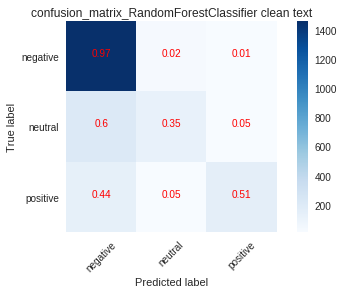

Normalized confusion matrix
[[ 0.88  0.09  0.04]
 [ 0.33  0.6   0.07]
 [ 0.17  0.07  0.76]]


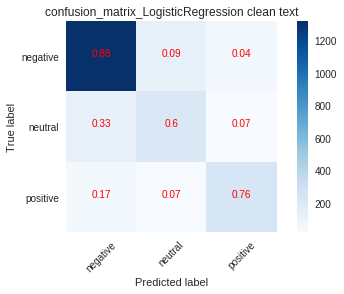

Normalized confusion matrix
[[ 0.95  0.03  0.02]
 [ 0.54  0.39  0.07]
 [ 0.31  0.04  0.65]]


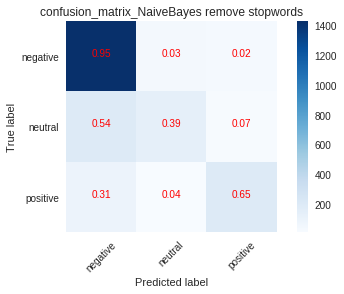

Normalized confusion matrix
[[ 0.87  0.09  0.04]
 [ 0.53  0.42  0.05]
 [ 0.22  0.16  0.62]]


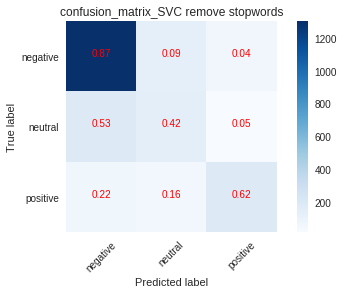

Normalized confusion matrix
[[ 0.85  0.1   0.05]
 [ 0.33  0.56  0.11]
 [ 0.2   0.12  0.69]]


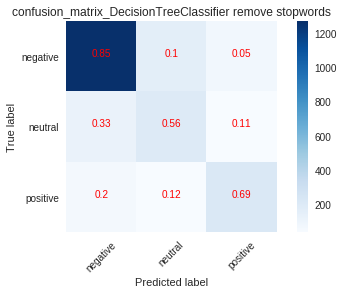

Normalized confusion matrix
[[ 0.9   0.07  0.03]
 [ 0.37  0.55  0.08]
 [ 0.27  0.09  0.63]]


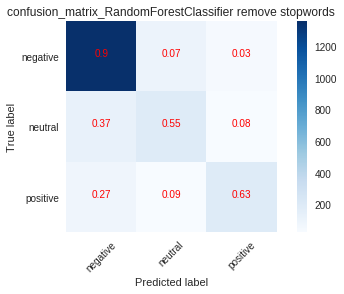

Normalized confusion matrix
[[ 0.86  0.1   0.05]
 [ 0.35  0.54  0.11]
 [ 0.22  0.1   0.68]]


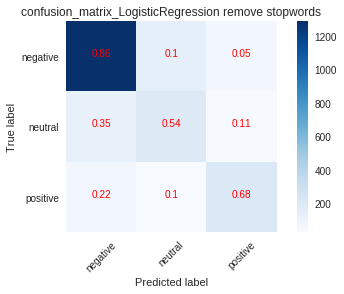

Normalized confusion matrix
[[ 0.95  0.03  0.02]
 [ 0.55  0.38  0.07]
 [ 0.28  0.05  0.67]]


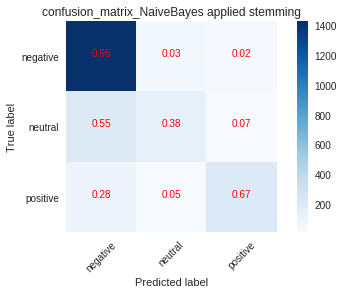

Normalized confusion matrix
[[ 0.84  0.12  0.04]
 [ 0.37  0.55  0.08]
 [ 0.24  0.18  0.58]]


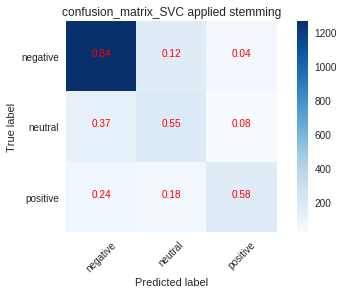

Normalized confusion matrix
[[ 0.86  0.09  0.04]
 [ 0.36  0.55  0.09]
 [ 0.25  0.09  0.65]]


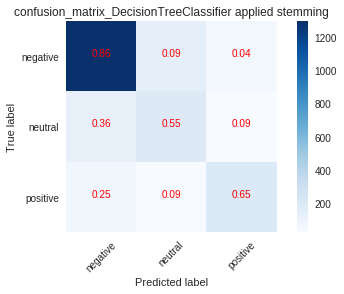

Normalized confusion matrix
[[ 0.9   0.07  0.03]
 [ 0.42  0.48  0.1 ]
 [ 0.25  0.09  0.66]]


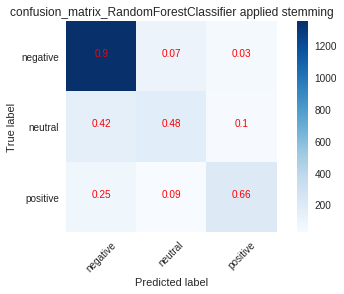

Normalized confusion matrix
[[ 0.84  0.11  0.05]
 [ 0.37  0.49  0.15]
 [ 0.26  0.13  0.61]]


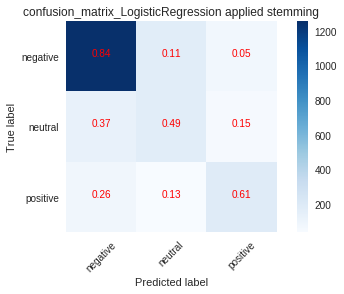

In [42]:
# Plot confusion matrices, for all models.
for k,conf_mtx in confusion_mtx.items():
    plot_confusion_matrix(conf_mtx, classes=target_names,
                          title= 'confusion_matrix_'+k,
                          isNorm='True')    

In [ ]:
model_results_df

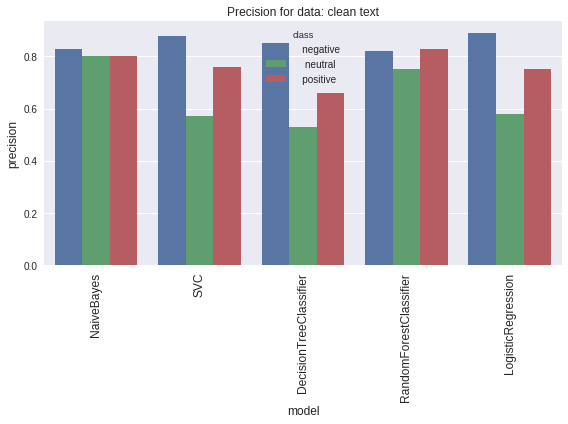

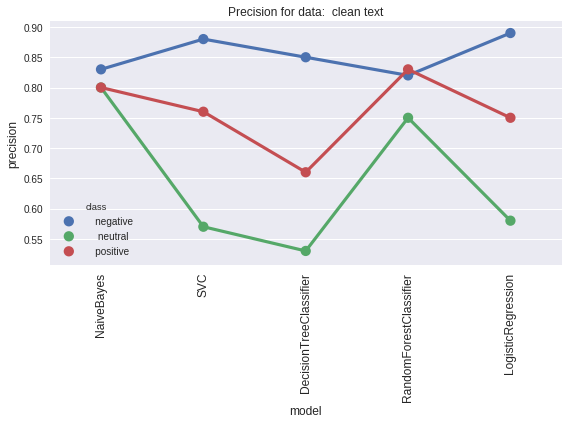

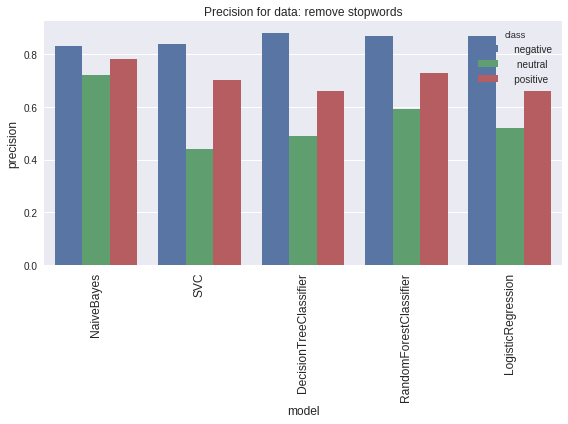

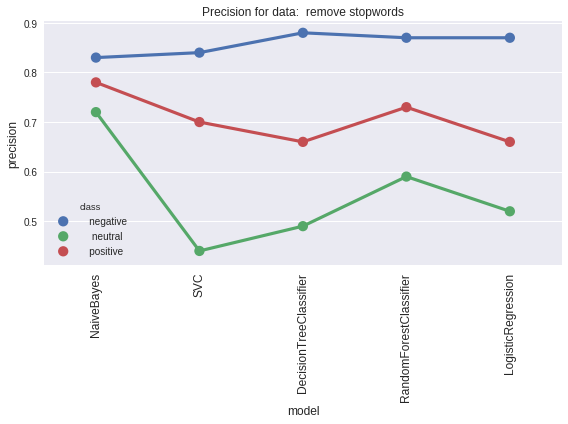

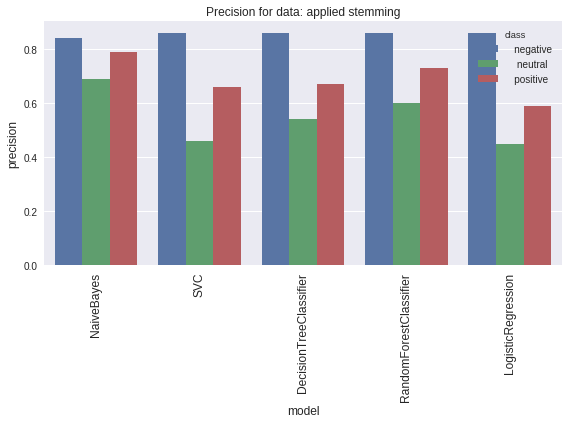

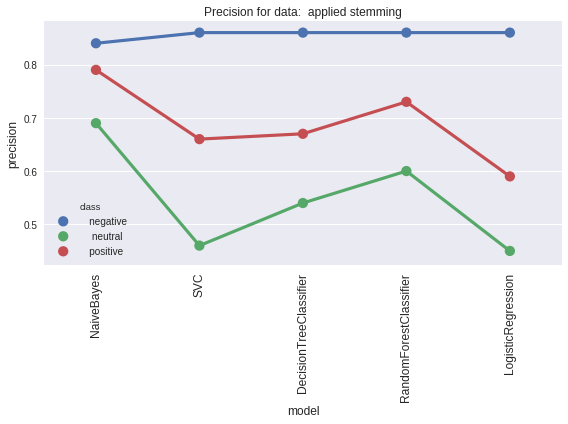

In [22]:
data_processing = ["clean text", "remove stopwords", "applied stemming"]
for data_type in data_processing: 
    x = "model"
    y = "precision"
    hue = "class"
    data = cl_report_df[cl_report_df.data_desc == data_type]
    plot_bar(data, x, y, hue, title = "Precision for data: "+ data_type)
    plt.tight_layout()
    plt.savefig(img_out_dir+'BM_BP_metric_precision_'+data_type+'.png')
    plot_point(data, x, y, hue, title = "Precision for data:  "+ data_type)
    plt.tight_layout()
    plt.savefig(img_out_dir+'BM_PP_metric_precision_'+data_type+'.png')

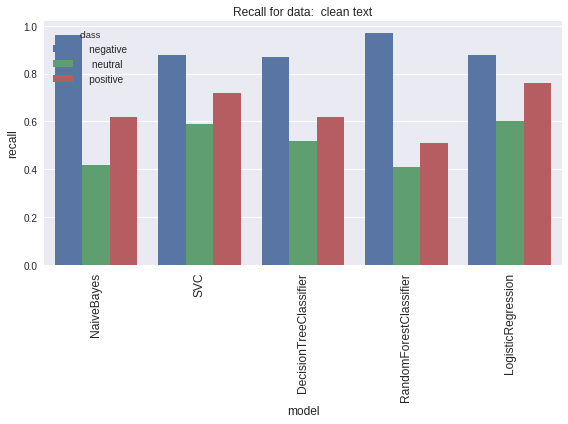

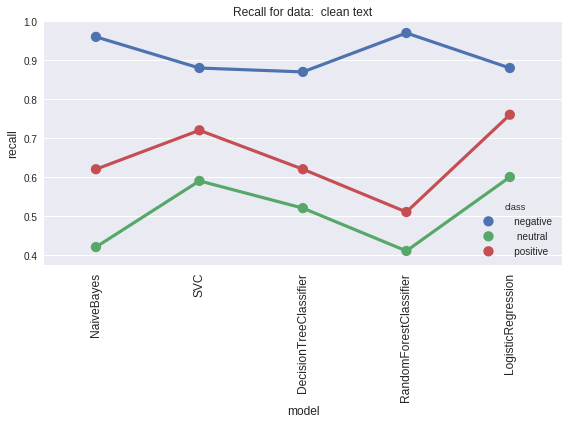

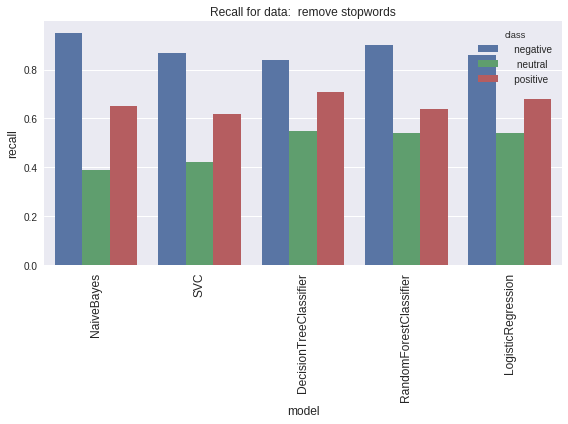

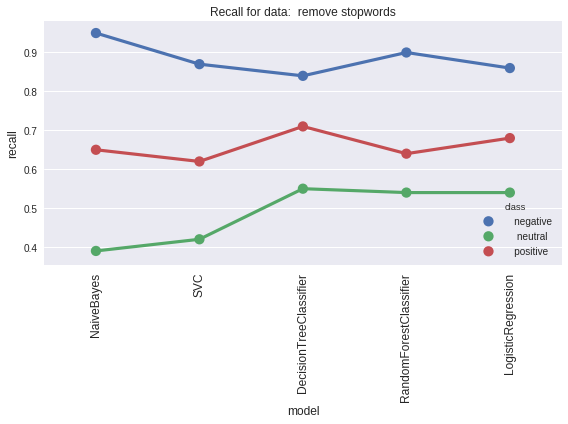

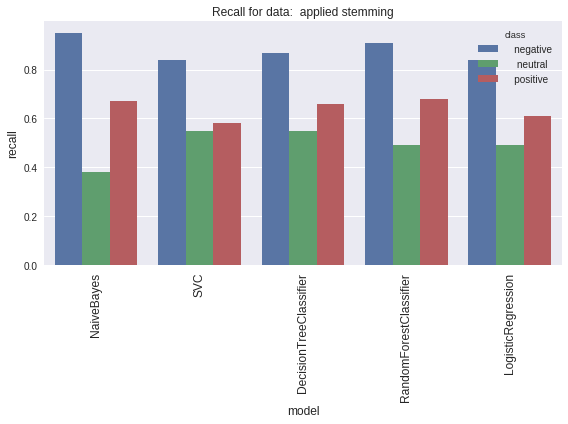

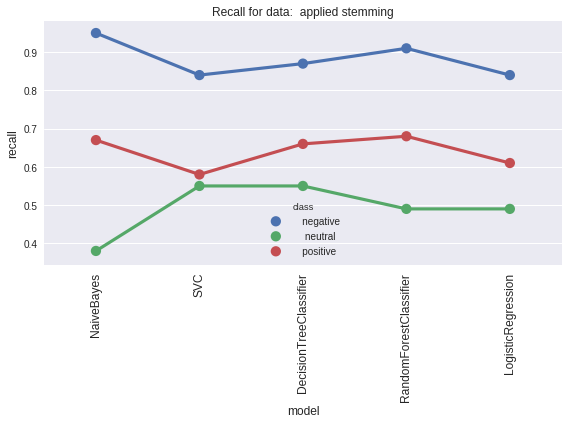

In [23]:
data_processing = ["clean text", "remove stopwords", "applied stemming"]
for data_type in data_processing: 
    x = "model"
    y = "recall" 
    hue = "class"
    data = cl_report_df[cl_report_df.data_desc == data_type]
    plot_bar(data, x, y, hue, title = "Recall for data:  "+ data_type)
    plt.tight_layout()
    plt.savefig(img_out_dir+'BM_BP_metric_recall_'+data_type+'.png')
    plot_point(data, x, y, hue, title = "Recall for data:  "+ data_type)
    plt.tight_layout()
    plt.savefig(img_out_dir+'BM_PP_metric_recall_'+data_type+'.png')


In [ ]:
#****** Some testing on how to transform a line of text to analyze sentiment with fit cv and models.

In [ ]:
# Predict sentiment in a line of text.

In [70]:
nb_pipe = model_results_df.pipe_object[0]

In [67]:
X_in = cv.transform(["it was amazing"])

In [68]:
nb_pipe.predict(X_in)

array([2])

In [72]:
prob = nb_pipe.predict_proba(X_in)

In [73]:
prob[0]

array([ 0.32005719,  0.08544638,  0.59449642])

In [74]:
prob[0][0]

0.32005719325259202

In [108]:
air_full_df[air_full_df.airline_sentiment == 'positive']['clean_text'].values[5]

"great deal! thinking 2nd trip australia & haven't gone 1st trip yet! ;p"

In [101]:
air_full_df[air_full_df.airline_sentiment == 'negative']['clean_text'].values[35]

'traveler miss flight late flight check bag? missed morning appointments lost business. #sfo2lax'

In [100]:
air_full_df[air_full_df.airline_sentiment == 'neutral']['clean_text'].values[35]

'"you rnp?" "yeah know me!"'